In [1]:
from utils import *

print_info()

Last run on: 2018-04-03
PyTorch version: 0.3.1.post2
fastai version: 0.6


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
torch.cuda.set_device(0)

In [3]:
PATH = Path('data/pascal/2007')

https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb

### Data preparation

Download the files from here and store them in PATH

[original website - unreliable](http://host.robots.ox.ac.uk/pascal/VOC/)

[faster mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/)

[json annotations](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip)

In [4]:
# !tar -xf {list(PATH.iterdir())[0]} -C {PATH}
# !unzip {PATH}/PASCAL_VOC.zip -d {PATH}

data preprocessing pipeline: https://gist.github.com/binga/1bc4ebe5e41f670f5954d2ffa9d6c0ed

In [5]:
with open(PATH/'PASCAL_VOC/pascal_train2007.json') as i:
    d = json.load(i)

print(d.keys())
    
categories = pd.DataFrame(d['categories'])
annotations = pd.DataFrame(d['annotations'])
images = pd.DataFrame(d['images'])

dict_keys(['images', 'type', 'annotations', 'categories'])


In [6]:
images.head()

file_name  height  id  width
0  000012.jpg     333  12    500
1  000017.jpg     364  17    480
2  000023.jpg     500  23    334
3  000026.jpg     333  26    500
4  000032.jpg     281  32    500

In [7]:
data = (annotations
        .merge(categories, how='left', left_on='category_id', right_on='id')
        .merge(images, how='left', left_on='image_id', right_on='id'))

In [8]:
data = data[data['ignore'] != 1]

In [9]:
largest_bbox = data.pivot_table(index='file_name', values='area', aggfunc=max).reset_index()
largest_bbox = largest_bbox.merge(data[['area', 'bbox', 'image_id', 'file_name', 'name']], how='left')

In [10]:
largest_bbox = largest_bbox[~largest_bbox['file_name'].duplicated()]

In [11]:
largest_bbox.head()

file_name    area                 bbox  image_id       name
0  000012.jpg   34104  [155, 96, 196, 174]        12        car
1  000017.jpg   81326   [89, 77, 314, 259]        17      horse
2  000023.jpg  111101     [2, 1, 241, 461]        23     person
3  000026.jpg   21824   [89, 124, 248, 88]        26        car
4  000032.jpg   28832  [103, 77, 272, 106]        32  aeroplane

In [12]:
largest_bbox['bbox_fastai'] = largest_bbox['bbox'].apply(lambda ary: bb_hw_to_fastai(ary))
largest_bbox['bbox_fastai_str'] = largest_bbox['bbox_fastai'].apply(lambda ary: ' '.join(str(coord) for coord in ary))
largest_bbox.rename(columns={'bbox': 'bbox_hw', 'name': 'category'}, inplace=True)
largest_bbox.head()

file_name    area              bbox_hw  image_id   category  \
0  000012.jpg   34104  [155, 96, 196, 174]        12        car   
1  000017.jpg   81326   [89, 77, 314, 259]        17      horse   
2  000023.jpg  111101     [2, 1, 241, 461]        23     person   
3  000026.jpg   21824   [89, 124, 248, 88]        26        car   
4  000032.jpg   28832  [103, 77, 272, 106]        32  aeroplane   

           bbox_fastai bbox_fastai_str  
0  [96, 155, 269, 350]  96 155 269 350  
1   [77, 89, 335, 402]   77 89 335 402  
2     [1, 2, 461, 242]     1 2 461 242  
3  [124, 89, 211, 336]  124 89 211 336  
4  [77, 103, 182, 374]  77 103 182 374

In [13]:
largest_bbox[['file_name', 'bbox_fastai_str']].to_csv(PATH/'largest_bbox_dataset.csv', index=False)
largest_bbox[['file_name', 'category']].to_csv(PATH/'category_dataset.csv', index=False)

In [14]:
ds_bbox = pd.read_csv(PATH/'largest_bbox_dataset.csv')
ds_category = pd.read_csv(PATH/'category_dataset.csv')
ds = ds_category.join(ds_bbox['bbox_fastai_str'])

In [15]:
ds.head()

file_name   category bbox_fastai_str
0  000012.jpg        car  96 155 269 350
1  000017.jpg      horse   77 89 335 402
2  000023.jpg     person     1 2 461 242
3  000026.jpg        car  124 89 211 336
4  000032.jpg  aeroplane  77 103 182 374

In [16]:
IMGS = PATH/'VOCdevkit'/'VOC2007'/'JPEGImages'

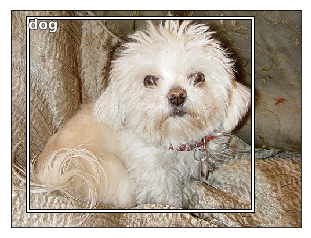

In [17]:
fn, cat, bb = ds.sample(1).iloc[0, :].values
show_image(IMGS/fn, cat, bb_fastai_to_hw(bb))

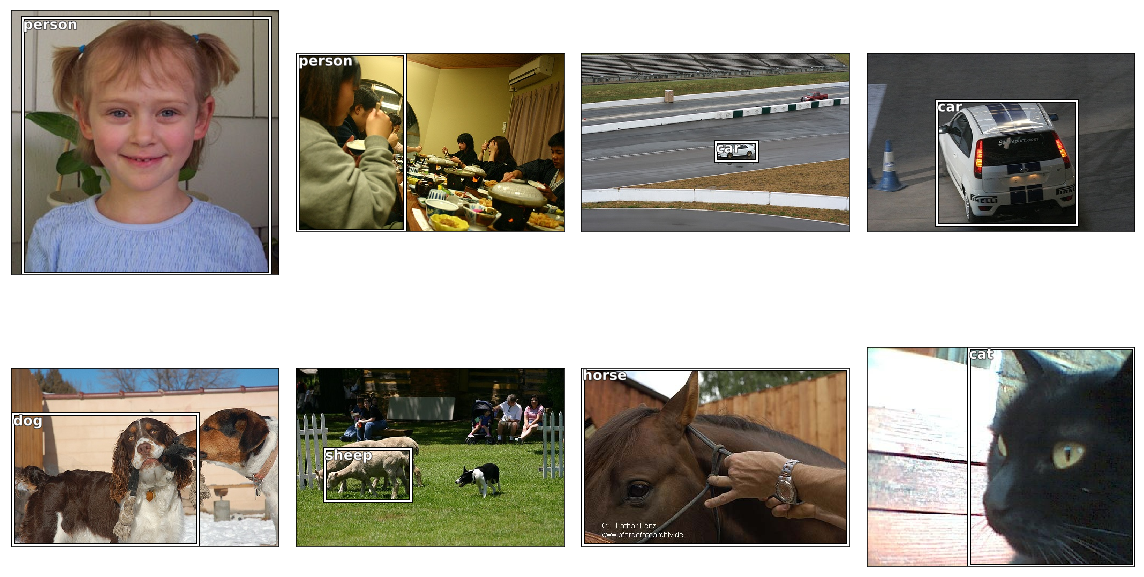

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

for ax in axes.flatten():
    fn, cat, bb = ds.sample(1).iloc[0, :].values
    bb = bb_fastai_to_hw(bb)
    
    show_image(IMGS/fn, cat, bb, ax)
plt.tight_layout()

##  Single object detection

In [19]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(ds), val_pct=0.1)

### Data augmentation

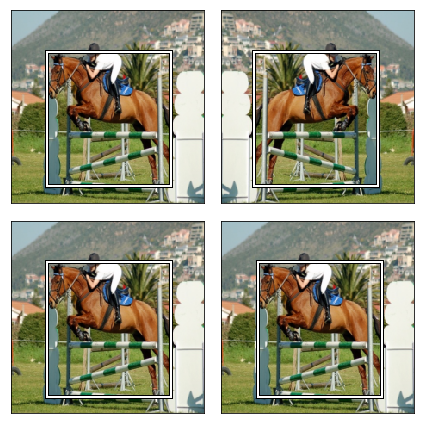

In [20]:
augs = [RandomFlip(tfm_y=TfmType.COORD)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, 'VOCdevkit/VOC2007/JPEGImages', PATH/'largest_bbox_dataset.csv',
                                  tfms=tfms, continuous=True, bs=4)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))

for ax in axes.flatten():
    im, bb = md.trn_ds[1]
    im = md.trn_ds.denorm(V(im)).squeeze()
    bb = bb_fastai_to_hw(bb)
    
    show_image(im, bbs=[bb], ax=ax)
plt.tight_layout()

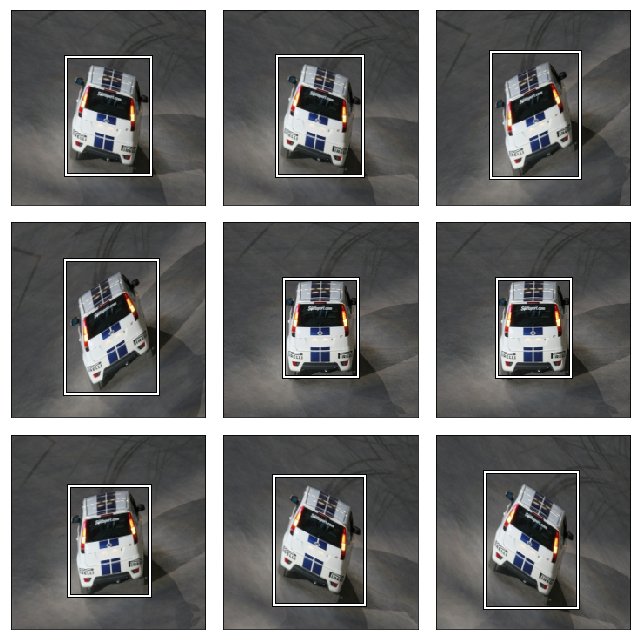

In [21]:
augs = [RandomRotate(30, tfm_y=TfmType.COORD)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, 'VOCdevkit/VOC2007/JPEGImages', PATH/'largest_bbox_dataset.csv',
                                  tfms=tfms, continuous=True, bs=4)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for ax in axes.flatten():
    im, bb = md.trn_ds[0]
    im = md.trn_ds.denorm(V(im)).squeeze()
    bb = bb_fastai_to_hw(bb)
    
    show_image(im, bbs=[bb], ax=ax)
plt.tight_layout()

Looks great! I will not use the transformations for the time being though as I first want to reproduce earlier performance as I clean up this notebook.

In [22]:
# augs = [RandomFlip(tfm_y=TfmType.COORD),
#         RandomRotate(30, tfm_y=TfmType.COORD),
#         RandomLighting(0.05,0.05, tfm_y=TfmType.COORD)]

tfms_loc=tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
tfms_det=tfms_from_model(f_model, sz, crop_type=CropType.NO)


md = ImageClassifierData.from_csv(PATH, 'VOCdevkit/VOC2007/JPEGImages', PATH/'largest_bbox_dataset.csv',
                                   bs, tfms_loc, val_idxs=val_idxs, continuous=True)

md2 = ImageClassifierData.from_csv(PATH, 'VOCdevkit/VOC2007/JPEGImages', PATH/'category_dataset.csv',
                                  bs, tfms_det, val_idxs=val_idxs)

In [23]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [24]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [25]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

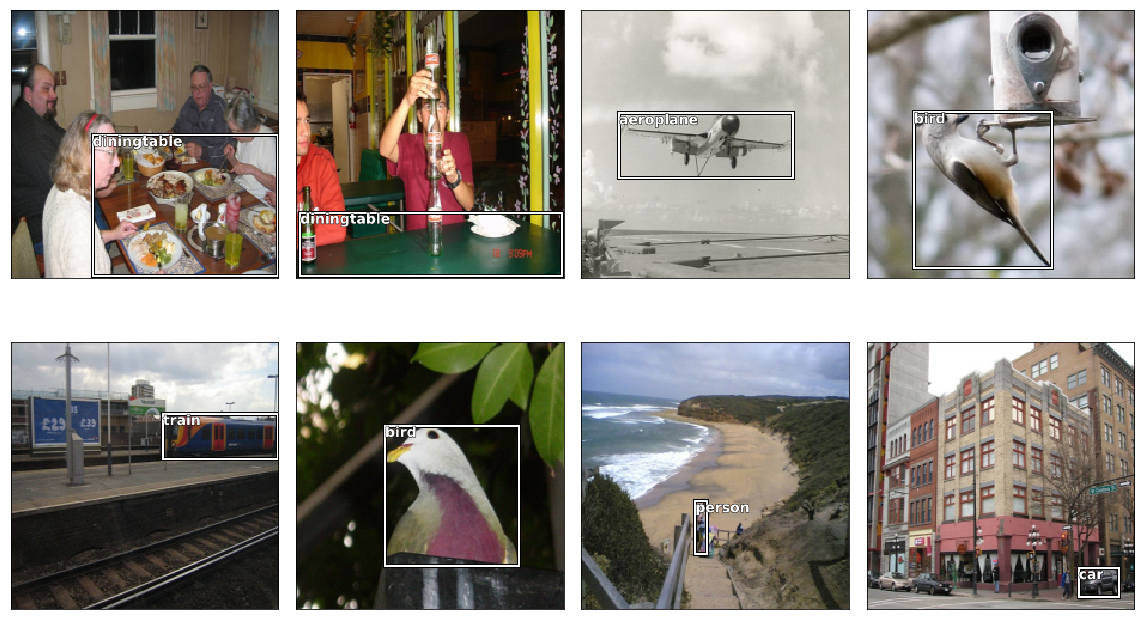

In [26]:
x,y=next(iter(md.trn_dl))
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

for i, ax in enumerate(axes.flatten()):
    im, bb, cat = x[i], y[0][i], md2.classes[y[1][i]]
    im = md2.trn_ds.denorm(im).squeeze()
    bb = bb_fastai_to_hw(bb)
    
    show_image(im, cat, bb, ax)
plt.tight_layout()

In [27]:
head_reg = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(md2.classes)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [28]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████  | 29/36 [00:04<00:01,  6.21it/s, loss=901] 


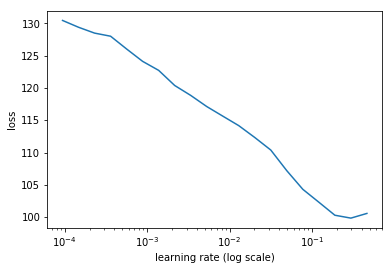

In [29]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [30]:
lr = 1e-2

In [31]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      69.278359  42.773781  0.804553   29.994514 
    1      49.490051  36.323859  0.79674    24.64029      
    2      40.195506  34.5467    0.824084   23.834453     



[34.54669952392578, 0.8240840584039688, 23.834453105926514]

In [32]:
learn.save('reg1_0')

In [33]:
learn.freeze_to(-2)

In [34]:
lrs = np.array([lr/100, lr/10, lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▉ | 32/36 [00:06<00:00,  4.78it/s, loss=163] 


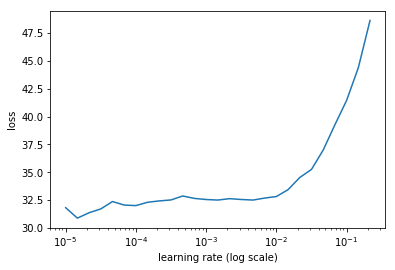

In [35]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [36]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      33.738343  36.37569   0.786907   22.796599 
    1      28.082205  33.308286  0.837689   21.296653     
    2      23.236235  31.479149  0.831088   20.277254     
    3      19.999565  30.431528  0.838497   19.766171     
    4      17.636495  30.607302  0.826374   19.780505     



[30.60730218887329, 0.8263739198446274, 19.780505180358887]

In [37]:
learn.save('reg1_1')

In [38]:
learn.unfreeze()

In [39]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      15.544791  31.810899  0.822064   20.06527  
    1      15.437606  32.06958   0.834995   19.883969     
    2      15.26952   30.751016  0.838901   19.521036     
    3      14.644842  30.95079   0.838901   19.0515       
    4      13.906678  31.835083  0.834995   19.069109     
    5      13.14462   31.259812  0.82597    19.083062     
    6      12.488915  30.871527  0.818561   18.847316     
    7      11.959247  30.144483  0.823276   18.699667     
    8      11.332496  30.0561    0.831088   18.616469     
    9      11.019574  29.740133  0.826778   18.572926     



[29.74013328552246, 0.8267780244350433, 18.57292604446411]

In [66]:
from scipy.special import expit

In [57]:
y = learn.predict()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


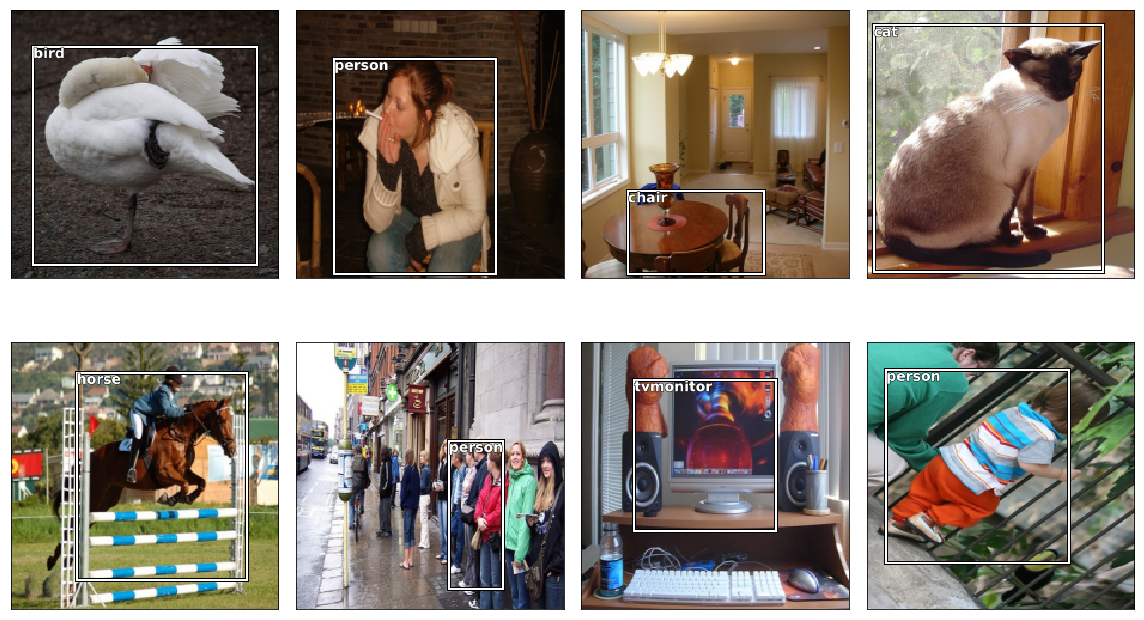

In [72]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

for i, ax in enumerate(axes.flatten()):
    im, bb, cat = md.val_ds[i][0], expit(y[i][:4]) * 224, md2.classes[np.argmax(y[i, 4:])]
    im = md2.trn_ds.denorm(im).squeeze()
    bb = bb_fastai_to_hw(bb)
    
    show_image(im, cat, bb, ax)
plt.tight_layout()